In [1]:
import pandas as pd
import numpy as np
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Input Data
data_folder = "../experiments/raw/galgo/"
networks = ["alarm", "cancer", "mildew", "barley", "child", "insurance", "water"]#, "earthquake"]
algorithms = ["ges", "hc", "pfhcbes", "pges", "phc"]
data_size = ["10k", "50k"]
threads = [2, 4, 6, 8]
interleaving = [5, 10, 15]
threads_str = list(map(lambda x: "T" + str(x), threads))
interleaving_str = list(map(lambda x: "I" + str(x), interleaving))
ending = "_global_results.csv"

In [3]:
# Creating dictionary with all the dataframes
dfs_net = {}
new_types={"Data Size (k)": "int", 
          "Network" : "string",
          "Algorithm": "string",
          "Threads": "int",
          "Interleaving": int
          }

# Output Files
output_folder = "../experiments/clean/galgo/"
ending1 = "experiments.csv"
ending2 = "delta_scores.csv"


In [10]:
# Falta por procesar pfhcbes
controls = {"pges": "ges",
           "phc" : "hc"}
measurements = ["SHD", "BDeu Score", "dfMM", "dfMM plus", "dfMM minus", "Total time(s)"]
#experiments = ["pges", "phc", "pfhcbes"]
#controls = ["ges", "hc"]
sizes = [10, 50]

In [4]:
def getSingleExperimentDataFrame(path):
    #print(path)
    df = pd.read_csv(path)
    p = re.compile(r'.*/(\w+)/(\w+)/\w+(\d\d)k')
    result = p.search(path)
    net = result.group(1)
    alg = result.group(2)
    data_size = result.group(3)
    threads = 0
    inter = 0
    
    if alg != "ges":
        p = re.compile(r'.*T(\d)_I(\d+)_global_results.csv')
        result = p.search(path)
        threads = result.group(1)
        inter = result.group(2)
    if(alg == "hc"):
        threads = 0
    df["Network"] = net
    df["Algorithm"] = alg
    df["Data Size (k)"] = data_size
    df["Threads"] = threads
    df["Interleaving"] = inter
        
    return df

In [5]:
# def getDeltaScores(df_exp, df_control, control_alg, measurements = ["SHD", "BDeu Score", "dfMM", "dfMM plus", "dfMM minus", "Total time(s)"]):

def getDeltaScores(df_exp, df_control, measurements = ["SHD", "BDeu Score", "dfMM", "dfMM plus", "dfMM minus", "Total time(s)"]):
    df_result = df_exp[measurements] - df_control[measurements].values.squeeze()
    df_result = df_result.add_suffix("_delta") #_" + control_alg)
    df_final = pd.concat([df_exp, df_result], axis=1)
    return df_final

In [6]:
def getDeltaDataFrame(df, controls):
    dfs_exp =[]
    sizes = [50,10]
    interleavings = [5,10,15]
    
    for exp in controls:
        control = controls[exp]
        for size in sizes:
            if(control == "hc"):
                for inter in interleaving:
                    df_exp = df.loc[(df["Algorithm"] == exp) & (df["Data Size (k)"] == size) & (df["Interleaving"] == inter)]
                    df_control = df.loc[(df["Algorithm"] == control) & (df["Data Size (k)"] == size) & (df["Interleaving"] == inter)]
                    df_result = getDeltaScores(df_exp, df_control)
                    dfs_exp.append(df_result)
            else:
                df_exp = df.loc[(df["Algorithm"] == exp) & (df["Data Size (k)"] == size)]
                df_control = df.loc[(df["Algorithm"] == control) & (df["Data Size (k)"] == size)]
                df_result = getDeltaScores(df_exp, df_control)
                dfs_exp.append(df_result)
    df_deltas = pd.concat(dfs_exp)
    df_deltas = df_deltas.sort_index()
    return df_deltas

In [7]:
def getPaths():
    paths= {}
    for net in networks:
        p = []
        for root, dirs, files in os.walk(data_folder + net):
            #for d in dirs:
            #    print(os.path.relpath(os.path.join(root, d), "."))
            for f in files:
                if (f != ".DS_Store"):
                    p.append(os.path.relpath(os.path.join(root, f), "."))
            if (len(p) != 0):
                paths[net] = p
    return paths

In [8]:
def getDataFrame(paths, networks):
    for net in networks:
        dfs = []
        for path in paths[net]:
            #print(path)
            dfs.append(getSingleExperimentDataFrame(path))
        df = pd.concat(dfs)
        df = df.reset_index(drop=True)
        df = df.astype(new_types)
        # Saving Dataframe of experiments
        df.to_csv(output_folder + net + ending1, index=False)
        dfs_net[net] = df
    

## Getting Delta Scores

In [11]:
df_alarm_delta = getDeltaDataFrame(dfs_net["alarm"], controls)
df_alarm_delta.head()

,SHD,BDeu Score,dfMM,dfMM plus,dfMM minus,Total iterations,Total time(s),Network,Algorithm,Data Size (k),Threads,Interleaving,SHD_delta,BDeu Score_delta,dfMM_delta,dfMM plus_delta,dfMM minus_delta,Total time(s)_delta
24,19,-531430.310419,1.081081,28.0,12.0,10.0,12,alarm,phc,50,2,5,-8.0,1747.237746,-0.648649,-18.0,-6.0,-2.0
25,27,-111107.856300,1.459459,22.0,32.0,4.0,3,alarm,phc,10,4,10,-11.0,723.016355,-0.324324,-10.0,-2.0,-1.0
26,34,-112166.442166,1.891892,34.0,36.0,3.0,4,alarm,phc,10,6,15,-4.0,-335.569512,0.108108,2.0,2.0,-1.0
27,35,-111543.043552,1.513514,24.0,32.0,4.0,3,alarm,phc,10,2,15,-3.0,287.829103,-0.270270,-8.0,-2.0,-1.0
28,48,-111642.757929,2.216216,42.0,40.0,4.0,16,alarm,phc,10,8,15,10.0,188.114725,0.432432,10.0,6.0,0.0


In [60]:
df_alarm_delta.to_csv(output_folder + "alarm/" + ending2, index=False)

In [16]:
df_alarm = dfs_net["alarm"]
#df_alarm.head()

In [18]:
df_alarm.loc[(df_alarm["Algorithm"]=="phc") & (df_alarm["Data Size (k)"] == 10)]

,SHD,BDeu Score,dfMM,dfMM plus,dfMM minus,Total iterations,Total time(s),Network,Algorithm,Data Size (k),Threads,Interleaving
25,27,-111107.856300,1.459459,22.0,32.0,4.0,3,alarm,phc,10,4,10
26,34,-112166.442166,1.891892,34.0,36.0,3.0,4,alarm,phc,10,6,15
27,35,-111543.043552,1.513514,24.0,32.0,4.0,3,alarm,phc,10,2,15
28,48,-111642.757929,2.216216,42.0,40.0,4.0,16,alarm,phc,10,8,15
31,30,-111306.131324,1.675676,28.0,34.0,4.0,4,alarm,phc,10,6,10
32,27,-111222.514445,1.567568,24.0,34.0,3.0,4,alarm,phc,10,4,15
33,47,-111586.389998,2.270270,48.0,36.0,4.0,15,alarm,phc,10,8,10
35,30,-111132.047875,1.783784,26.0,40.0,6.0,3,alarm,phc,10,2,10
36,44,-111410.215512,1.729730,30.0,34.0,10.0,3,alarm,phc,10,2,5
41,45,-111582.641867,1.837838,36.0,32.0,5.0,15,alarm,phc,10,8,5


In [27]:
df_alarm.loc[df_alarm["Algorithm"]=="hc"] \
        .groupby(["Network", "Algorithm", "Data Size (k)", "Threads", "Interleaving"], as_index = False) \
        .first()


,Network,Algorithm,Data Size (k),Threads,Interleaving,SHD,BDeu Score,dfMM,dfMM plus,dfMM minus,Total iterations,Total time(s)
0,alarm,hc,10,0,5,38,-111830.872655,1.783784,32.0,34.0,11.0,3
1,alarm,hc,10,0,10,38,-111830.872655,1.783784,32.0,34.0,6.0,4
2,alarm,hc,10,0,15,38,-111830.872655,1.783784,32.0,34.0,5.0,5
3,alarm,hc,50,0,5,27,-533177.548165,1.729730,46.0,18.0,13.0,14
4,alarm,hc,50,0,10,27,-533177.548165,1.729730,46.0,18.0,7.0,11
5,alarm,hc,50,0,15,27,-533177.548165,1.729730,46.0,18.0,5.0,5


In [20]:
df_alarm.loc[(df_alarm["Algorithm"]=="hc") & (df_alarm["Data Size (k)"] == 10)]

,SHD,BDeu Score,dfMM,dfMM plus,dfMM minus,Total iterations,Total time(s),Network,Algorithm,Data Size (k),Threads,Interleaving
1,38,-111830.872655,1.783784,32.0,34.0,6.0,4,alarm,hc,10,0,10
2,38,-111830.872655,1.783784,32.0,34.0,5.0,5,alarm,hc,10,0,15
3,38,-111830.872655,1.783784,32.0,34.0,5.0,4,alarm,hc,10,0,15
4,38,-111830.872655,1.783784,32.0,34.0,5.0,16,alarm,hc,10,0,15
7,38,-111830.872655,1.783784,32.0,34.0,6.0,4,alarm,hc,10,0,10
8,38,-111830.872655,1.783784,32.0,34.0,5.0,4,alarm,hc,10,0,15
9,38,-111830.872655,1.783784,32.0,34.0,6.0,16,alarm,hc,10,0,10
11,38,-111830.872655,1.783784,32.0,34.0,6.0,3,alarm,hc,10,0,10
12,38,-111830.872655,1.783784,32.0,34.0,11.0,3,alarm,hc,10,0,5
17,38,-111830.872655,1.783784,32.0,34.0,11.0,15,alarm,hc,10,0,5


In [28]:
df_alarm.loc[(df_alarm["Algorithm"]=="pges") & (df_alarm["Data Size (k)"] == 10)]

,SHD,BDeu Score,dfMM,dfMM plus,dfMM minus,Total iterations,Total time(s),Network,Algorithm,Data Size (k),Threads,Interleaving
33,28,-112204.014341,1.567568,20.0,38.0,5.0,1,alarm,pges,10,4,10
34,37,-112654.684783,2.216216,40.0,42.0,5.0,1,alarm,pges,10,6,15
35,19,-110127.753682,1.135135,12.0,30.0,8.0,1,alarm,pges,10,2,15
36,30,-111703.947886,1.837838,26.0,42.0,5.0,2,alarm,pges,10,8,15
39,22,-111426.096095,1.297297,10.0,38.0,5.0,1,alarm,pges,10,6,10
40,18,-111001.514573,1.405405,16.0,36.0,6.0,1,alarm,pges,10,4,15
41,36,-112211.914757,2.324324,40.0,46.0,5.0,1,alarm,pges,10,8,10
43,16,-110310.651169,0.810811,10.0,20.0,8.0,1,alarm,pges,10,2,10
44,17,-110675.386019,0.972973,8.0,28.0,8.0,1,alarm,pges,10,2,5
49,21,-111218.051023,1.243243,12.0,34.0,5.0,1,alarm,pges,10,8,5


In [34]:
df_alarm_delta_10k = df_alarm_delta.loc[df_alarm_delta["Data Size (k)"] == 10]
df_alarm_delta_50k = df_alarm_delta.loc[df_alarm_delta["Data Size (k)"] == 50]

In [39]:
df_alarm_delta.loc[(df_alarm_delta["Data Size (k)"] == 10) & (df_alarm_delta["Interleaving"] == 5)]

,SHD,BDeu Score,dfMM,dfMM plus,dfMM minus,Total iterations,Total time(s),Network,Algorithm,Data Size (k),Threads,Interleaving,SHD_delta,BDeu Score_delta,dfMM_delta,dfMM plus_delta,dfMM minus_delta,Total time(s)_delta
18,26,-111178.167331,1.675676,26.0,36.0,8.0,1,alarm,phc,10,2,5,-12.0,652.705324,-0.108108,-6.0,2.0,1.0
23,47,-111963.693118,2.594595,48.0,48.0,5.0,0,alarm,phc,10,8,5,9.0,-132.820464,0.810811,16.0,14.0,0.0
26,32,-111657.593665,1.891892,32.0,38.0,7.0,0,alarm,phc,10,6,5,-6.0,173.278990,0.108108,0.0,4.0,0.0
29,52,-111708.960337,2.162162,44.0,36.0,7.0,0,alarm,phc,10,4,5,14.0,121.912318,0.378378,12.0,2.0,0.0
44,17,-110675.386019,0.972973,8.0,28.0,8.0,1,alarm,pges,10,2,5,1.0,-183.141170,-0.054054,-4.0,2.0,0.0
49,21,-111218.051023,1.243243,12.0,34.0,5.0,1,alarm,pges,10,8,5,5.0,-725.806174,0.216216,0.0,8.0,0.0
52,20,-110559.615428,1.243243,14.0,32.0,7.0,1,alarm,pges,10,6,5,4.0,-67.370579,0.216216,2.0,6.0,0.0
55,32,-111661.196159,1.729730,24.0,40.0,8.0,0,alarm,pges,10,4,5,16.0,-1168.951310,0.702703,12.0,14.0,-1.0


In [ ]:
df_alarm_delta.to_csv()

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

In [56]:
def plot_delta_score(df_delta, data_size, interleaving):
    fig = plt.figure(figsize=(16,9))
    df = df_delta.loc[(df_delta["Data Size (k)"] == data_size) & (df_alarm_delta["Interleaving"] == interleaving)]
    ax = sns.barplot(x ="Threads", y="BDeu Score_delta", hue="Algorithm", data=df)
    plt.title("BDEU DELTA SCORE " + str(data_size) + "k instances for " + str(interleaving) + " interleaving")
    return ax


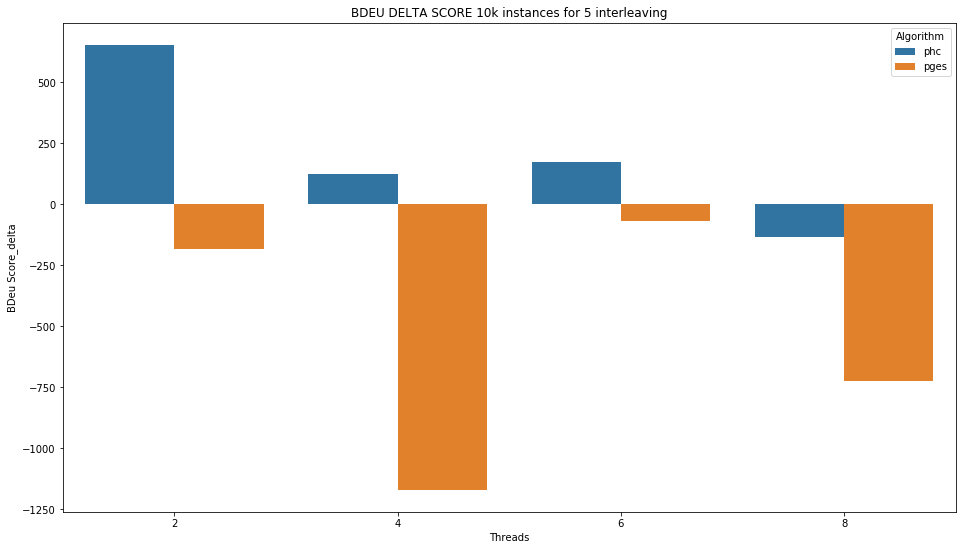

In [57]:
plot_delta_score(df_alarm_delta, 10, 5)

In [ ]:
plot_delta_score(df_alarm_delta, 10, 5)

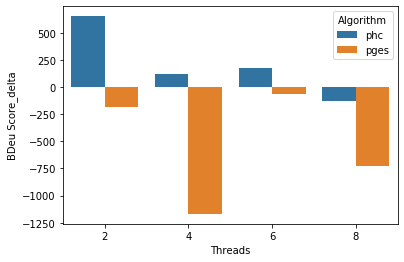

In [40]:
# ax = sns.barplot(x="day", y="total_bill", hue="sex", data=tips)
df = df_alarm_delta.loc[(df_alarm_delta["Data Size (k)"] == 10) & (df_alarm_delta["Interleaving"] == 5)]
ax = sns.barplot(x ="Threads", y="BDeu Score_delta", hue="Algorithm", data=df)

In [12]:
### NOT WORKING FOR ALL THE NETWORKS (NOT ALL THE EXPERIMENTS WERE SUCCESFUL IN OTHER NETS)
df_deltas = {}
for net in networks:
    print(net)
    df = dfs_net[net]
    df2 = getDeltaDataFrame(df, controls)
    df_deltas[net] = df2
    df2.to_csv(output_folder + net + ending2, index=False)

alarm
cancer
earthquake
mildew


ValueError: Unable to coerce to DataFrame, shape must be (7, 6): given (0, 6)

In [16]:
df_prueba = dfs_net["mildew"]
df_prueba.loc[df_prueba["Algorithm"] == "ges"]

,SHD,BDeu Score,dfMM,dfMM plus,dfMM minus,Total iterations,Total time(s),Network,Algorithm,Data Size (k),Threads,Interleaving


In [13]:
getDeltaDataFrame(dfs_net["mildew"], controls)

ValueError: Unable to coerce to DataFrame, shape must be (7, 6): given (0, 6)

In [ ]:
df["Algorithm"].value_counts()

In [ ]:
df1 = df.loc[(df["Algorithm"] == "pges") & (df["Data Size (k)"] == 50)]

In [ ]:
df2 = df.loc[(df["Algorithm"] == "ges") & (df["Data Size (k)"] == 50)]

In [ ]:
df.loc[(df["Algorithm"] == "hc")]

In [ ]:
df_delta_ges_50 = getDeltaScores(df1, df2)
df_delta_ges_50

In [ ]:
df_control = df.loc[(df["Algorithm"] == "hc") & (df["Data Size (k)"] == 10) & (df["Interleaving"] == 5)]
df_exp = df.loc[(df["Algorithm"] == "phc") & (df["Data Size (k)"] == 10) & (df["Interleaving"] == 5)]
df_res = getDeltaScores(df_exp, df_control)

In [ ]:
df_control

In [ ]:
df_exp

In [ ]:
df_res

In [ ]:
df_deltas = getDeltaDataFrame(df, controls)
df_deltas.head()

In [ ]:
df_deltas.to_csv("../experiments/local/clean/networks/alarm/delta_scores.csv")

In [ ]:
df_deltas.shape

In [ ]:
#df_exp = df.loc[(df["Algorithm"] == exp) & (df["Data Size (k)"] == size)]
df.loc[(df["Algorithm"] == "hc") & (df["Data Size (k)"] == 50) & (df["Interleaving"] == 5)]

In [ ]:
df2

In [ ]:
measurements = ["SHD", "BDeu Score", "dfMM", "dfMM plus", "dfMM minus", "Total time(s)"]

In [ ]:
df3 = df1[measurements] - df2[measurements].values.squeeze()
df3.head()

In [ ]:
df3.add_suffix("_delta_ges")